In [1]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from sklearn.metrics import classification_report, f1_score


Using TensorFlow backend.


In [2]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder


### Function that returns labels encoded to numbers ###
def labelEncoder1(train_y, dev_y, test_y):
    normalizer = LabelEncoder()
    train_y = normalizer.fit_transform(train_y)
    dev_y = normalizer.transform(dev_y)
    test_y = normalizer.transform(test_y)
    return train_y, dev_y, test_y


### Preprocessing function ###
def strip(text):
    t = text.lower()
    t = re.sub('\&amp;', ' ', t)
    t = re.sub('http\S+', ' ', t)
    t = re.sub('@\w+', ' ', t)
    t = re.sub("[^\w']", ' ', t)
    t = re.sub('\s+', ' ', t)
    return t

### Stats of dataset ###
def explore(df):
    print('Observations:', len(df.index))
    for label in set(df.label):
        print('{:.2f} % {}'.format(len(df[df.label == label])/df.shape[0]*100, label))

### Loading Dataset ###
def load_dataset(path):
    columns = ['id', 'topic', 'label', 'text']
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    df = df[df.text != 'Not Available']
    df.reset_index(drop=True, inplace=True)
    df.text = df.text.apply(lambda x: strip(x))
    return df

In [3]:
# set parameters:
max_features = 5000
#maxlen = 400
t_batch_size = [32,64]
t_embedding_dims = [50,100]
t_nof_filters = [25,50]
t_kernel_size = [3,6]
t_hidden_dims = [50,100]
t_epochs = [5,10]
t_fit_size = [1,2]

In [4]:
### Training Dataset #####
train_df = load_dataset("./train_2_labels.csv")
explore(train_df)
x_train = train_df.text
y_train = train_df.label
print(x_train.shape, y_train.shape)

### Dev Dataset #####
dev_df = load_dataset('./dev_2_labels.csv')
explore(dev_df)
x_dev = dev_df.text
y_dev = dev_df.label
print(x_dev.shape, y_dev.shape)

### Test Dataset #####
test_df = load_dataset('./test_2_labels.csv')
explore(test_df)
x_test = test_df.text
y_test = test_df.label
print(x_test.shape, y_test.shape)
print(x_train[0])

y_train, y_dev, y_test = labelEncoder1(y_train, y_dev, y_test)

print('Loading data...')

tkn = Tokenizer(num_words=max_features)
tkn.fit_on_texts(x_train)
x_train = tkn.texts_to_sequences(x_train)
x_dev = tkn.texts_to_sequences(x_dev)
x_test = tkn.texts_to_sequences(x_test)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print(x_train[0])

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train)
maxlen= len(x_train[0])
x_dev = sequence.pad_sequences(x_dev, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train[0])
print(y_train[0])

Observations: 3422
16.98 % negative
83.02 % positive
(3422,) (3422,)
Observations: 1058
26.18 % negative
73.82 % positive
(1058,) (1058,)
Observations: 1105
19.46 % negative
80.54 % positive
(1105,) (1105,)
dear the newooffice for mac is great and all but no lync update c'mon 
Loading data...
3422 train sequences
1105 test sequences
[795, 1, 3572, 9, 138, 10, 106, 6, 27, 24, 93, 3573, 437, 415]
Pad sequences (samples x time)
x_train shape: (3422, 33)
x_test shape: (1105, 33)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  795    1 3572    9  138   10  106    6   27   24   93
 3573  437  415]
0


In [5]:
import itertools
import pandas as pd
total = list(itertools.product(*[t_batch_size,t_embedding_dims,t_nof_filters,t_kernel_size,t_hidden_dims,t_epochs,t_fit_size]))
df = pd.DataFrame(0, index=range(len(total)), columns=["batch_size","embedding_dims","nof_filters","kernel_size","hidden_dims","epochs","fit_size","f1_score"])

for i,elem in enumerate(total):
    (batch_size,embedding_dims,nof_filters,kernel_size,hidden_dims,epochs,fit_size) = elem
    print(i+1,'.Build model...')

    model = Sequential()
    model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Conv1D(nof_filters, kernel_size, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print( model.summary() )

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    history = model.fit(
        x_train[:int(len(x_train)/fit_size)],              # features
        y_train[:int(len(y_train)/fit_size)],              # labels
        epochs=epochs,                     # numbers of epoch
        batch_size=batch_size,        # define batch size
        verbose=1,                    # the most extended verbose
        validation_split=0.1          # 90% for train and 10% for validation
    )

    predictions = model.predict_classes(x_dev, verbose=1)

    df.loc[i,:] = elem+(f1_score(y_dev,predictions),)

df.sort_values(by="f1_score",ascending=False,inplace=True)
df

1 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 50)            250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 25)            3775      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0  

Train on 1539 samples, validate on 172 samples
Epoch 1/10
1539/1539 [==============================] - 4s 2ms/step - loss: 0.5843 - acc: 0.7713 - val_loss: 0.2701 - val_acc: 0.9709
Epoch 2/10
1539/1539 [==============================] - 1s 741us/step - loss: 0.4982 - acc: 0.7979 - val_loss: 0.3415 - val_acc: 0.9709
Epoch 3/10
1539/1539 [==============================] - 1s 747us/step - loss: 0.4665 - acc: 0.7979 - val_loss: 0.2933 - val_acc: 0.9709
Epoch 4/10
1539/1539 [==============================] - 1s 762us/step - loss: 0.3888 - acc: 0.7999 - val_loss: 0.3505 - val_acc: 0.9709
Epoch 5/10
1539/1539 [==============================] - 1s 747us/step - loss: 0.2786 - acc: 0.8986 - val_loss: 0.2815 - val_acc: 0.9360
Epoch 6/10
1539/1539 [==============================] - 1s 741us/step - loss: 0.1704 - acc: 0.9578 - val_loss: 0.3075 - val_acc: 0.8721
Epoch 7/10
1539/1539 [==============================] - 1s 757us/step - loss: 0.0973 - acc: 0.9805 - val_loss: 0.3684 - val_acc: 0.8140
Epo

3079/3079 [==============================] - 2s 804us/step - loss: 0.2213 - acc: 0.9269 - val_loss: 0.4350 - val_acc: 0.7901
Epoch 5/10
3079/3079 [==============================] - 3s 837us/step - loss: 0.1410 - acc: 0.9614 - val_loss: 0.5584 - val_acc: 0.7405
Epoch 6/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.0848 - acc: 0.9769 - val_loss: 0.6633 - val_acc: 0.7289
Epoch 7/10
3079/3079 [==============================] - 3s 829us/step - loss: 0.0420 - acc: 0.9903 - val_loss: 0.5994 - val_acc: 0.7843
Epoch 8/10
3079/3079 [==============================] - 3s 814us/step - loss: 0.0209 - acc: 0.9961 - val_loss: 0.7427 - val_acc: 0.7551
Epoch 9/10
3079/3079 [==============================] - 2s 794us/step - loss: 0.0133 - acc: 0.9977 - val_loss: 0.8192 - val_acc: 0.7493
Epoch 10/10
1058/1058 [==============================] - 0s 459us/step
8 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape 

1539/1539 [==============================] - 1s 823us/step - loss: 0.4672 - acc: 0.7979 - val_loss: 0.2401 - val_acc: 0.9709
Epoch 4/5
1539/1539 [==============================] - 1s 804us/step - loss: 0.3342 - acc: 0.8343 - val_loss: 0.2812 - val_acc: 0.9709
Epoch 5/5
1058/1058 [==============================] - 1s 706us/step
11 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_21 (Dropout)         (None, 33, 50)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 28, 25)            7525      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 25)                0         
__________________________________________________________

3079/3079 [==============================] - 6s 2ms/step - loss: 0.5088 - acc: 0.8139 - val_loss: 0.2842 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 3s 827us/step - loss: 0.4230 - acc: 0.8162 - val_loss: 0.3431 - val_acc: 0.9563
Epoch 3/5
3079/3079 [==============================] - 3s 819us/step - loss: 0.2680 - acc: 0.8938 - val_loss: 0.4514 - val_acc: 0.7843
Epoch 4/5
3079/3079 [==============================] - 3s 829us/step - loss: 0.1508 - acc: 0.9526 - val_loss: 0.3550 - val_acc: 0.8688
Epoch 5/5
1058/1058 [==============================] - 1s 788us/step
14 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_27 (Dropout)         (None, 33, 50)            0         
______________________________________________________

Epoch 5/10
1539/1539 [==============================] - 1s 888us/step - loss: 0.1912 - acc: 0.9539 - val_loss: 0.4141 - val_acc: 0.8140
Epoch 6/10
1539/1539 [==============================] - 1s 869us/step - loss: 0.0893 - acc: 0.9818 - val_loss: 0.4398 - val_acc: 0.8081
Epoch 7/10
1539/1539 [==============================] - 1s 878us/step - loss: 0.0371 - acc: 0.9948 - val_loss: 0.5355 - val_acc: 0.7733
Epoch 8/10
1539/1539 [==============================] - 1s 880us/step - loss: 0.0179 - acc: 0.9981 - val_loss: 0.7240 - val_acc: 0.6919
Epoch 9/10
1539/1539 [==============================] - 1s 857us/step - loss: 0.0094 - acc: 0.9994 - val_loss: 0.6544 - val_acc: 0.7442
Epoch 10/10
1058/1058 [==============================] - 1s 914us/step
17 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 33, 50)            250000    
________________________________

Epoch 9/10
3079/3079 [==============================] - 3s 819us/step - loss: 0.0077 - acc: 0.9987 - val_loss: 0.6391 - val_acc: 0.8309
Epoch 10/10
1058/1058 [==============================] - 1s 1ms/step
20 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_39 (Dropout)         (None, 33, 50)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 31, 50)            7550      
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 50)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 50)                2550      
__________________________________________________

Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 7s 2ms/step - loss: 0.4956 - acc: 0.8142 - val_loss: 0.2728 - val_acc: 0.9563
Epoch 2/10
3079/3079 [==============================] - 3s 897us/step - loss: 0.4145 - acc: 0.8165 - val_loss: 0.3239 - val_acc: 0.9563
Epoch 3/10
3079/3079 [==============================] - 3s 902us/step - loss: 0.2769 - acc: 0.8935 - val_loss: 0.3562 - val_acc: 0.8484
Epoch 4/10
3079/3079 [==============================] - 3s 942us/step - loss: 0.1717 - acc: 0.9464 - val_loss: 0.5049 - val_acc: 0.7697
Epoch 5/10
3079/3079 [==============================] - 3s 938us/step - loss: 0.1036 - acc: 0.9701 - val_loss: 0.5640 - val_acc: 0.7755
Epoch 6/10
3079/3079 [==============================] - 3s 922us/step - loss: 0.0530 - acc: 0.9873 - val_loss: 0.6394 - val_acc: 0.7726
Epoch 7/10
3079/3079 [==============================] - 3s 837us/step - loss: 0.0222 - acc: 0.9945 - val_loss: 0.6419 - val_acc: 0.7930
Epo

Train on 1539 samples, validate on 172 samples
Epoch 1/5
1539/1539 [==============================] - 6s 4ms/step - loss: 0.5526 - acc: 0.7947 - val_loss: 0.3408 - val_acc: 0.9709
Epoch 2/5
1539/1539 [==============================] - 2s 988us/step - loss: 0.4932 - acc: 0.7979 - val_loss: 0.2945 - val_acc: 0.9709
Epoch 3/5
1539/1539 [==============================] - 2s 992us/step - loss: 0.4265 - acc: 0.7979 - val_loss: 0.3069 - val_acc: 0.9709
Epoch 4/5
1539/1539 [==============================] - 2s 977us/step - loss: 0.2769 - acc: 0.8811 - val_loss: 0.2775 - val_acc: 0.9186
Epoch 5/5
1058/1058 [==============================] - 2s 1ms/step
27 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_53 (Dropout)         (None, 33, 50)            0         

Train on 3079 samples, validate on 343 samples
Epoch 1/5
3079/3079 [==============================] - 8s 3ms/step - loss: 0.5067 - acc: 0.8064 - val_loss: 0.2822 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 3s 982us/step - loss: 0.4105 - acc: 0.8188 - val_loss: 0.3262 - val_acc: 0.9359
Epoch 3/5
3079/3079 [==============================] - 3s 977us/step - loss: 0.2472 - acc: 0.9081 - val_loss: 0.4173 - val_acc: 0.8105
Epoch 4/5
3079/3079 [==============================] - 3s 992us/step - loss: 0.1357 - acc: 0.9529 - val_loss: 0.5175 - val_acc: 0.7872
Epoch 5/5
1058/1058 [==============================] - 2s 2ms/step
30 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_59 (Dropout)         (None, 33, 50)            0         

Epoch 5/10
1539/1539 [==============================] - 2s 998us/step - loss: 0.1230 - acc: 0.9695 - val_loss: 0.3724 - val_acc: 0.8488
Epoch 6/10
1539/1539 [==============================] - 2s 987us/step - loss: 0.0511 - acc: 0.9864 - val_loss: 0.4872 - val_acc: 0.7849
Epoch 7/10
1539/1539 [==============================] - 2s 998us/step - loss: 0.0143 - acc: 0.9968 - val_loss: 0.4849 - val_acc: 0.8140
Epoch 8/10
1539/1539 [==============================] - 2s 992us/step - loss: 0.0058 - acc: 0.9994 - val_loss: 0.5208 - val_acc: 0.8081
Epoch 9/10
1539/1539 [==============================] - 2s 977us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4684 - val_acc: 0.8314
Epoch 10/10
1058/1058 [==============================] - 2s 2ms/step
33 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 33, 100)           500000    
__________________________________

Epoch 9/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0041 - acc: 0.9997 - val_loss: 0.6005 - val_acc: 0.8309
Epoch 10/10
1058/1058 [==============================] - 2s 2ms/step
36 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 33, 100)           500000    
_________________________________________________________________
dropout_71 (Dropout)         (None, 33, 100)           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 31, 25)            7525      
_________________________________________________________________
global_max_pooling1d_36 (Glo (None, 25)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 50)                1300      
____________________________________________________

Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 10s 3ms/step - loss: 0.4956 - acc: 0.8139 - val_loss: 0.2870 - val_acc: 0.9563
Epoch 2/10
3079/3079 [==============================] - 4s 1ms/step - loss: 0.3714 - acc: 0.8282 - val_loss: 0.2468 - val_acc: 0.9534
Epoch 3/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.2169 - acc: 0.9201 - val_loss: 0.3181 - val_acc: 0.8921
Epoch 4/10
3079/3079 [==============================] - 4s 1ms/step - loss: 0.1052 - acc: 0.9704 - val_loss: 0.3240 - val_acc: 0.8980
Epoch 5/10
3079/3079 [==============================] - 4s 1ms/step - loss: 0.0401 - acc: 0.9909 - val_loss: 0.4460 - val_acc: 0.8251
Epoch 6/10
3079/3079 [==============================] - 4s 1ms/step - loss: 0.0159 - acc: 0.9968 - val_loss: 0.4917 - val_acc: 0.8397
Epoch 7/10
3079/3079 [==============================] - 4s 1ms/step - loss: 0.0083 - acc: 0.9987 - val_loss: 0.5837 - val_acc: 0.8134
Epoch 8/10
307

Train on 1539 samples, validate on 172 samples
Epoch 1/5
1539/1539 [==============================] - 9s 6ms/step - loss: 0.5675 - acc: 0.7947 - val_loss: 0.3443 - val_acc: 0.9709
Epoch 2/5
1539/1539 [==============================] - 2s 2ms/step - loss: 0.4885 - acc: 0.7979 - val_loss: 0.2461 - val_acc: 0.9709
Epoch 3/5
1539/1539 [==============================] - 3s 2ms/step - loss: 0.4045 - acc: 0.8044 - val_loss: 0.2818 - val_acc: 0.9709
Epoch 4/5
1539/1539 [==============================] - 3s 2ms/step - loss: 0.2177 - acc: 0.9240 - val_loss: 0.2370 - val_acc: 0.9477
Epoch 5/5
1058/1058 [==============================] - 2s 2ms/step
43 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 33, 100)           500000    
_________________________________________________________________
dropout_85 (Dropout)         (None, 33, 100)           0         
_____

Train on 3079 samples, validate on 343 samples
Epoch 1/5
3079/3079 [==============================] - 12s 4ms/step - loss: 0.5130 - acc: 0.8006 - val_loss: 0.2990 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 5s 2ms/step - loss: 0.4020 - acc: 0.8214 - val_loss: 0.2727 - val_acc: 0.9504
Epoch 3/5
3079/3079 [==============================] - 5s 2ms/step - loss: 0.2311 - acc: 0.9178 - val_loss: 0.3263 - val_acc: 0.8776
Epoch 4/5
3079/3079 [==============================] - 5s 2ms/step - loss: 0.1056 - acc: 0.9721 - val_loss: 0.4325 - val_acc: 0.8163
Epoch 5/5
1058/1058 [==============================] - 2s 2ms/step
46 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 33, 100)           500000    
_________________________________________________________________
dropout_91 (Dropout)         (None, 33, 100)           0         
____

Epoch 5/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.1199 - acc: 0.9740 - val_loss: 0.4264 - val_acc: 0.7907
Epoch 6/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0610 - acc: 0.9877 - val_loss: 0.5195 - val_acc: 0.7558
Epoch 7/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0296 - acc: 0.9948 - val_loss: 0.5706 - val_acc: 0.7558
Epoch 8/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0135 - acc: 0.9987 - val_loss: 0.7798 - val_acc: 0.7035
Epoch 9/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0108 - acc: 0.9987 - val_loss: 0.7977 - val_acc: 0.7267 loss: 0.0072 - acc: 0.
Epoch 10/10
1058/1058 [==============================] - 3s 2ms/step
49 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 33, 100)           500000    
_____________________

3079/3079 [==============================] - 5s 1ms/step - loss: 0.0040 - acc: 0.9997 - val_loss: 0.6168 - val_acc: 0.8251
Epoch 10/10
1058/1058 [==============================] - 3s 3ms/step
52 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 33, 100)           500000    
_________________________________________________________________
dropout_103 (Dropout)        (None, 33, 100)           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 31, 50)            15050     
_________________________________________________________________
global_max_pooling1d_52 (Glo (None, 50)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 50)                2550      
_______________________________________________________________

Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 12s 4ms/step - loss: 0.4916 - acc: 0.8152 - val_loss: 0.2643 - val_acc: 0.9563
Epoch 2/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.3790 - acc: 0.8279 - val_loss: 0.2858 - val_acc: 0.9300
Epoch 3/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.2321 - acc: 0.9117 - val_loss: 0.2949 - val_acc: 0.8980
Epoch 4/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.1159 - acc: 0.9636 - val_loss: 0.4242 - val_acc: 0.8280
Epoch 5/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0449 - acc: 0.9890 - val_loss: 0.5997 - val_acc: 0.7813
Epoch 6/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0142 - acc: 0.9974 - val_loss: 0.6159 - val_acc: 0.7930
Epoch 7/10
3079/3079 [==============================] - 5s 2ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.6249 - val_acc: 0.8192
Epoch 8/10
307

Train on 1539 samples, validate on 172 samples
Epoch 1/5
1539/1539 [==============================] - 11s 7ms/step - loss: 0.5290 - acc: 0.7979 - val_loss: 0.3076 - val_acc: 0.9709
Epoch 2/5
1539/1539 [==============================] - 3s 2ms/step - loss: 0.4762 - acc: 0.7979 - val_loss: 0.2644 - val_acc: 0.9709
Epoch 3/5
1539/1539 [==============================] - 3s 2ms/step - loss: 0.3565 - acc: 0.8265 - val_loss: 0.2581 - val_acc: 0.9651
Epoch 4/5
1539/1539 [==============================] - 3s 2ms/step - loss: 0.1782 - acc: 0.9519 - val_loss: 0.2865 - val_acc: 0.9012
Epoch 5/5
1058/1058 [==============================] - 3s 3ms/step
59 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_59 (Embedding)     (None, 33, 100)           500000    
_________________________________________________________________
dropout_117 (Dropout)        (None, 33, 100)           0         
____

Train on 3079 samples, validate on 343 samples
Epoch 1/5
3079/3079 [==============================] - 14s 4ms/step - loss: 0.4882 - acc: 0.8129 - val_loss: 0.2976 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 6s 2ms/step - loss: 0.3637 - acc: 0.8357 - val_loss: 0.2447 - val_acc: 0.9475
Epoch 3/5
3079/3079 [==============================] - 6s 2ms/step - loss: 0.1956 - acc: 0.9321 - val_loss: 0.4267 - val_acc: 0.8076
Epoch 4/5
3079/3079 [==============================] - 6s 2ms/step - loss: 0.0846 - acc: 0.9773 - val_loss: 0.4388 - val_acc: 0.8251
Epoch 5/5
1058/1058 [==============================] - 3s 3ms/step
62 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 33, 100)           500000    
_________________________________________________________________
dropout_123 (Dropout)        (None, 33, 100)           0         
____

Epoch 5/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0572 - acc: 0.9864 - val_loss: 0.4269 - val_acc: 0.8140
Epoch 6/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0185 - acc: 0.9961 - val_loss: 0.4996 - val_acc: 0.8198
Epoch 7/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0057 - acc: 0.9994 - val_loss: 0.4532 - val_acc: 0.8372
Epoch 8/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4850 - val_acc: 0.8256
Epoch 9/10
1539/1539 [==============================] - 3s 2ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.5253 - val_acc: 0.8256
Epoch 10/10
1058/1058 [==============================] - 3s 3ms/step
65 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_65 (Embedding)     (None, 33, 50)            250000    
____________________________________________

Epoch 9/10
3079/3079 [==============================] - 2s 586us/step - loss: 0.0365 - acc: 0.9922 - val_loss: 0.4602 - val_acc: 0.8309
Epoch 10/10
1058/1058 [==============================] - 4s 3ms/step
68 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_135 (Dropout)        (None, 33, 50)            0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 31, 25)            3775      
_________________________________________________________________
global_max_pooling1d_68 (Glo (None, 25)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 50)                1300      
__________________________________________________

Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 11s 4ms/step - loss: 0.5665 - acc: 0.7730 - val_loss: 0.2599 - val_acc: 0.9563
Epoch 2/10
3079/3079 [==============================] - 2s 581us/step - loss: 0.4632 - acc: 0.8162 - val_loss: 0.2755 - val_acc: 0.9563
Epoch 3/10
3079/3079 [==============================] - 2s 586us/step - loss: 0.4113 - acc: 0.8162 - val_loss: 0.2749 - val_acc: 0.9563
Epoch 4/10
3079/3079 [==============================] - 2s 586us/step - loss: 0.3154 - acc: 0.8597 - val_loss: 0.3185 - val_acc: 0.9125
Epoch 5/10
3079/3079 [==============================] - 2s 581us/step - loss: 0.2177 - acc: 0.9318 - val_loss: 0.3414 - val_acc: 0.8542
Epoch 6/10
3079/3079 [==============================] - 2s 581us/step - loss: 0.1531 - acc: 0.9539 - val_loss: 0.4302 - val_acc: 0.8076
Epoch 7/10
3079/3079 [==============================] - 2s 586us/step - loss: 0.1036 - acc: 0.9704 - val_loss: 0.4415 - val_acc: 0.8222
Ep

Train on 1539 samples, validate on 172 samples
Epoch 1/5
1539/1539 [==============================] - 11s 7ms/step - loss: 0.6071 - acc: 0.7947 - val_loss: 0.3726 - val_acc: 0.9709
Epoch 2/5
1539/1539 [==============================] - 1s 672us/step - loss: 0.5042 - acc: 0.7979 - val_loss: 0.2783 - val_acc: 0.9709
Epoch 3/5
1539/1539 [==============================] - 1s 696us/step - loss: 0.4821 - acc: 0.7979 - val_loss: 0.2954 - val_acc: 0.9709
Epoch 4/5
1539/1539 [==============================] - 1s 672us/step - loss: 0.4587 - acc: 0.7979 - val_loss: 0.2960 - val_acc: 0.9709
Epoch 5/5
1058/1058 [==============================] - 4s 4ms/step
75 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_75 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_149 (Dropout)        (None, 33, 50)            0        

Train on 3079 samples, validate on 343 samples
Epoch 1/5
3079/3079 [==============================] - 12s 4ms/step - loss: 0.5217 - acc: 0.8162 - val_loss: 0.2884 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 2s 662us/step - loss: 0.4717 - acc: 0.8162 - val_loss: 0.2887 - val_acc: 0.9563
Epoch 3/5
3079/3079 [==============================] - 2s 669us/step - loss: 0.4303 - acc: 0.8162 - val_loss: 0.2874 - val_acc: 0.9563
Epoch 4/5
3079/3079 [==============================] - 2s 674us/step - loss: 0.3027 - acc: 0.8503 - val_loss: 0.3146 - val_acc: 0.9038
Epoch 5/5
1058/1058 [==============================] - 4s 4ms/step
78 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_78 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_155 (Dropout)        (None, 33, 50)            0        

1539/1539 [==============================] - 1s 737us/step - loss: 0.4864 - acc: 0.7979 - val_loss: 0.2814 - val_acc: 0.9709
Epoch 5/10
1539/1539 [==============================] - 1s 751us/step - loss: 0.4479 - acc: 0.7979 - val_loss: 0.3008 - val_acc: 0.9709
Epoch 6/10
1539/1539 [==============================] - 1s 875us/step - loss: 0.3543 - acc: 0.8018 - val_loss: 0.2811 - val_acc: 0.9709
Epoch 7/10
1539/1539 [==============================] - 1s 827us/step - loss: 0.2275 - acc: 0.9227 - val_loss: 0.2894 - val_acc: 0.9302
Epoch 8/10
1539/1539 [==============================] - 1s 829us/step - loss: 0.1232 - acc: 0.9792 - val_loss: 0.3048 - val_acc: 0.8953
Epoch 9/10
1539/1539 [==============================] - 1s 845us/step - loss: 0.0584 - acc: 0.9870 - val_loss: 0.2951 - val_acc: 0.8779
Epoch 10/10
1058/1058 [==============================] - 5s 5ms/step
81 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape

Epoch 8/10
3079/3079 [==============================] - 2s 751us/step - loss: 0.0423 - acc: 0.9906 - val_loss: 0.5086 - val_acc: 0.8163
Epoch 9/10
3079/3079 [==============================] - 2s 736us/step - loss: 0.0221 - acc: 0.9971 - val_loss: 0.5223 - val_acc: 0.8280
Epoch 10/10
1058/1058 [==============================] - 5s 5ms/step
84 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_84 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_167 (Dropout)        (None, 33, 50)            0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 31, 50)            7550      
_________________________________________________________________
global_max_pooling1d_84 (Glo (None, 50)                0         
______________________________________________

Total params: 262,751
Trainable params: 262,751
Non-trainable params: 0
_________________________________________________________________
None
Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 15s 5ms/step - loss: 0.5361 - acc: 0.7938 - val_loss: 0.2809 - val_acc: 0.9563
Epoch 2/10
3079/3079 [==============================] - 2s 694us/step - loss: 0.4606 - acc: 0.8162 - val_loss: 0.2774 - val_acc: 0.9563
Epoch 3/10
3079/3079 [==============================] - 2s 704us/step - loss: 0.3986 - acc: 0.8162 - val_loss: 0.3084 - val_acc: 0.9563
Epoch 4/10
3079/3079 [==============================] - 2s 705us/step - loss: 0.2931 - acc: 0.8659 - val_loss: 0.4051 - val_acc: 0.8163
Epoch 5/10
3079/3079 [==============================] - 2s 701us/step - loss: 0.1980 - acc: 0.9399 - val_loss: 0.5327 - val_acc: 0.7522
Epoch 6/10
3079/3079 [==============================] - 2s 694us/step - loss: 0.1224 - acc: 0.9646 - val_loss: 0.5775 - val_acc: 0.

Train on 1539 samples, validate on 172 samples
Epoch 1/5
1539/1539 [==============================] - 13s 8ms/step - loss: 0.5898 - acc: 0.7524 - val_loss: 0.2754 - val_acc: 0.9709
Epoch 2/5
1539/1539 [==============================] - 1s 823us/step - loss: 0.5032 - acc: 0.7979 - val_loss: 0.3138 - val_acc: 0.9709
Epoch 3/5
1539/1539 [==============================] - 1s 796us/step - loss: 0.4885 - acc: 0.7979 - val_loss: 0.2777 - val_acc: 0.9709
Epoch 4/5
1539/1539 [==============================] - 1s 792us/step - loss: 0.4566 - acc: 0.7979 - val_loss: 0.2828 - val_acc: 0.9709
Epoch 5/5
1058/1058 [==============================] - 5s 5ms/step
91 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_91 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_181 (Dropout)        (None, 33, 50)            0        

Train on 3079 samples, validate on 343 samples
Epoch 1/5
3079/3079 [==============================] - 15s 5ms/step - loss: 0.5147 - acc: 0.8162 - val_loss: 0.2803 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 3s 814us/step - loss: 0.4550 - acc: 0.8162 - val_loss: 0.2636 - val_acc: 0.9563
Epoch 3/5
3079/3079 [==============================] - 3s 837us/step - loss: 0.3667 - acc: 0.8191 - val_loss: 0.3158 - val_acc: 0.9563
Epoch 4/5
3079/3079 [==============================] - 3s 909us/step - loss: 0.2445 - acc: 0.9143 - val_loss: 0.3615 - val_acc: 0.8542
Epoch 5/5
1058/1058 [==============================] - 5s 5ms/step
94 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_94 (Embedding)     (None, 33, 50)            250000    
_________________________________________________________________
dropout_187 (Dropout)        (None, 33, 50)            0        

1539/1539 [==============================] - 1s 877us/step - loss: 0.4575 - acc: 0.7979 - val_loss: 0.2825 - val_acc: 0.9709
Epoch 5/10
1539/1539 [==============================] - 1s 824us/step - loss: 0.3707 - acc: 0.7986 - val_loss: 0.2918 - val_acc: 0.9709
Epoch 6/10
1539/1539 [==============================] - 1s 817us/step - loss: 0.2566 - acc: 0.8785 - val_loss: 0.3333 - val_acc: 0.9012
Epoch 7/10
1539/1539 [==============================] - 1s 837us/step - loss: 0.1570 - acc: 0.9636 - val_loss: 0.3356 - val_acc: 0.8721
Epoch 8/10
1539/1539 [==============================] - 1s 846us/step - loss: 0.0885 - acc: 0.9812 - val_loss: 0.3727 - val_acc: 0.8605
Epoch 9/10
1539/1539 [==============================] - 1s 847us/step - loss: 0.0504 - acc: 0.9890 - val_loss: 0.4914 - val_acc: 0.8198
Epoch 10/10
1058/1058 [==============================] - 5s 5ms/step
97 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape

Epoch 8/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.0262 - acc: 0.9971 - val_loss: 0.5419 - val_acc: 0.8105
Epoch 9/10
3079/3079 [==============================] - 3s 979us/step - loss: 0.0138 - acc: 0.9994 - val_loss: 0.4614 - val_acc: 0.8484
Epoch 10/10
1058/1058 [==============================] - 5s 5ms/step
100 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_100 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_199 (Dropout)        (None, 33, 100)           0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 31, 25)            7525      
_________________________________________________________________
global_max_pooling1d_100 (Gl (None, 25)                0         
_______________________________________________

Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 17s 6ms/step - loss: 0.5468 - acc: 0.7730 - val_loss: 0.2857 - val_acc: 0.9563
Epoch 2/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.4553 - acc: 0.8162 - val_loss: 0.2892 - val_acc: 0.9563
Epoch 3/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.3485 - acc: 0.8399 - val_loss: 0.2973 - val_acc: 0.9417
Epoch 4/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.2080 - acc: 0.9259 - val_loss: 0.2549 - val_acc: 0.9213
Epoch 5/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.1160 - acc: 0.9662 - val_loss: 0.3174 - val_acc: 0.8630
Epoch 6/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.0514 - acc: 0.9864 - val_loss: 0.3601 - val_acc: 0.8513
Epoch 7/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.0224 - acc: 0.9968 - val_loss: 0.3980 - val_acc: 0.8484
Epoch 8/10
307

Train on 1539 samples, validate on 172 samples
Epoch 1/5
1539/1539 [==============================] - 15s 10ms/step - loss: 0.6269 - acc: 0.7251 - val_loss: 0.3593 - val_acc: 0.9709
Epoch 2/5
1539/1539 [==============================] - 2s 1ms/step - loss: 0.5121 - acc: 0.7979 - val_loss: 0.3078 - val_acc: 0.9709
Epoch 3/5
1539/1539 [==============================] - 2s 1ms/step - loss: 0.4988 - acc: 0.7979 - val_loss: 0.2928 - val_acc: 0.9709
Epoch 4/5
1539/1539 [==============================] - 2s 1ms/step - loss: 0.4771 - acc: 0.7979 - val_loss: 0.2620 - val_acc: 0.9709
Epoch 5/5
1058/1058 [==============================] - 6s 6ms/step
107 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_107 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_213 (Dropout)        (None, 33, 100)           0         
__

Train on 3079 samples, validate on 343 samples
Epoch 1/5
3079/3079 [==============================] - 17s 6ms/step - loss: 0.5203 - acc: 0.8087 - val_loss: 0.2954 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 3s 1ms/step - loss: 0.4536 - acc: 0.8162 - val_loss: 0.2564 - val_acc: 0.9563
Epoch 3/5
3079/3079 [==============================] - 3s 1ms/step - loss: 0.3553 - acc: 0.8262 - val_loss: 0.3192 - val_acc: 0.9417
Epoch 4/5
3079/3079 [==============================] - 3s 1ms/step - loss: 0.2190 - acc: 0.9272 - val_loss: 0.4033 - val_acc: 0.8192
Epoch 5/5
1058/1058 [==============================] - 6s 5ms/step
110 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_110 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_219 (Dropout)        (None, 33, 100)           0         
___

Epoch 5/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.3353 - acc: 0.7992 - val_loss: 0.3008 - val_acc: 0.9709
Epoch 6/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.2265 - acc: 0.9272 - val_loss: 0.2632 - val_acc: 0.9477
Epoch 7/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.1423 - acc: 0.9786 - val_loss: 0.2771 - val_acc: 0.9186
Epoch 8/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.0749 - acc: 0.9903 - val_loss: 0.2926 - val_acc: 0.9070
Epoch 9/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.0330 - acc: 0.9955 - val_loss: 0.3201 - val_acc: 0.8837
Epoch 10/10
1058/1058 [==============================] - 6s 6ms/step
113 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_113 (Embedding)    (None, 33, 100)           500000    
___________________________________________

3079/3079 [==============================] - 3s 1ms/step - loss: 0.0108 - acc: 0.9990 - val_loss: 0.4168 - val_acc: 0.8717
Epoch 10/10
1058/1058 [==============================] - 6s 6ms/step
116 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_116 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_231 (Dropout)        (None, 33, 100)           0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 31, 50)            15050     
_________________________________________________________________
global_max_pooling1d_116 (Gl (None, 50)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 50)                2550      
______________________________________________________________

Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 18s 6ms/step - loss: 0.5142 - acc: 0.8133 - val_loss: 0.2792 - val_acc: 0.9563
Epoch 2/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.4421 - acc: 0.8162 - val_loss: 0.2697 - val_acc: 0.9563
Epoch 3/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.3415 - acc: 0.8305 - val_loss: 0.2657 - val_acc: 0.9534
Epoch 4/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.2239 - acc: 0.9240 - val_loss: 0.3366 - val_acc: 0.8805
Epoch 5/10
3079/3079 [==============================] - 3s 1ms/step - loss: 0.1245 - acc: 0.9652 - val_loss: 0.4850 - val_acc: 0.7843
Epoch 6/10
3079/3079 [==============================] - 4s 1ms/step - loss: 0.0655 - acc: 0.9825 - val_loss: 0.4319 - val_acc: 0.8630
Epoch 7/10
3079/3079 [==============================] - 4s 1ms/step - loss: 0.0283 - acc: 0.9945 - val_loss: 0.5027 - val_acc: 0.8542
Epoch 8/10
307

Train on 1539 samples, validate on 172 samples
Epoch 1/5
1539/1539 [==============================] - 17s 11ms/step - loss: 0.5588 - acc: 0.7862 - val_loss: 0.2190 - val_acc: 0.9709
Epoch 2/5
1539/1539 [==============================] - 2s 1ms/step - loss: 0.4991 - acc: 0.7979 - val_loss: 0.3045 - val_acc: 0.9709
Epoch 3/5
1539/1539 [==============================] - 2s 1ms/step - loss: 0.4794 - acc: 0.7979 - val_loss: 0.2798 - val_acc: 0.9709
Epoch 4/5
1539/1539 [==============================] - 2s 1ms/step - loss: 0.4032 - acc: 0.7979 - val_loss: 0.2669 - val_acc: 0.9709
Epoch 5/5
1058/1058 [==============================] - 6s 6ms/step
123 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_123 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_245 (Dropout)        (None, 33, 100)           0         
__

3079/3079 [==============================] - 19s 6ms/step - loss: 0.5230 - acc: 0.8071 - val_loss: 0.2990 - val_acc: 0.9563
Epoch 2/5
3079/3079 [==============================] - 4s 1ms/step - loss: 0.4322 - acc: 0.8162 - val_loss: 0.2481 - val_acc: 0.9563
Epoch 3/5
3079/3079 [==============================] - 4s 1ms/step - loss: 0.2981 - acc: 0.8704 - val_loss: 0.3506 - val_acc: 0.8630
Epoch 4/5
3079/3079 [==============================] - 4s 1ms/step - loss: 0.1674 - acc: 0.9454 - val_loss: 0.4703 - val_acc: 0.7872
Epoch 5/5
1058/1058 [==============================] - 7s 6ms/step
126 .Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_126 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_251 (Dropout)        (None, 33, 100)           0         
____________________________________________________________

1539/1539 [==============================] - 2s 1ms/step - loss: 0.2092 - acc: 0.9318 - val_loss: 0.2779 - val_acc: 0.9128
Epoch 6/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.0940 - acc: 0.9792 - val_loss: 0.3341 - val_acc: 0.8663
Epoch 7/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.0365 - acc: 0.9929 - val_loss: 0.3908 - val_acc: 0.8430
Epoch 8/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.0158 - acc: 0.9987 - val_loss: 0.3670 - val_acc: 0.8547
Epoch 9/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.0071 - acc: 0.9994 - val_loss: 0.3994 - val_acc: 0.8488
Epoch 10/10
1058/1058 [==============================] - 7s 6ms/step


,batch_size,embedding_dims,nof_filters,kernel_size,hidden_dims,epochs,fit_size,f1_score
113,64,100,50,3,50,5,2,0.853617
97,64,100,25,3,50,5,2,0.853216
121,64,100,50,6,50,5,2,0.852459
117,64,100,50,3,100,5,2,0.851873
105,64,100,25,6,50,5,2,0.851832
33,32,100,25,3,50,5,2,0.851429
96,64,100,25,3,50,5,1,0.850962
89,64,50,50,6,50,5,2,0.850136
77,64,50,25,6,100,5,2,0.850000
109,64,100,25,6,100,5,2,0.849480


Build model...
0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_151 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_301 (Dropout)        (None, 33, 100)           0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 31, 50)            15050     
_________________________________________________________________
global_max_pooling1d_151 (Gl (None, 50)                0         
_________________________________________________________________
dense_301 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_302 (Dropout)        (None, 50)                0         
_________________________________________________________________
activation_301 (Activation)  (None, 50)                0 

Train on 1232 samples, validate on 137 samples
Epoch 1/5
1232/1232 [==============================] - 20s 16ms/step - loss: 0.5999 - acc: 0.7979 - val_loss: 0.4861 - val_acc: 0.8467
Epoch 2/5
1232/1232 [==============================] - 1s 1ms/step - loss: 0.4651 - acc: 0.8263 - val_loss: 0.4311 - val_acc: 0.8467
Epoch 3/5
1232/1232 [==============================] - 1s 1ms/step - loss: 0.4500 - acc: 0.8263 - val_loss: 0.4418 - val_acc: 0.8467
Epoch 4/5
1232/1232 [==============================] - 1s 1ms/step - loss: 0.4309 - acc: 0.8263 - val_loss: 0.4345 - val_acc: 0.8467
Epoch 5/5
1105/1105 [==============================] - 0s 411us/step
0.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_155 (Embedding)    (None, 33, 100)           500000    
_________________________________________________________________
dropout_309 (Dropout)        (None, 33, 100)           0         
________________

Total params: 517,651
Trainable params: 517,651
Non-trainable params: 0
_________________________________________________________________
None
Train on 2464 samples, validate on 274 samples
Epoch 1/5
2464/2464 [==============================] - 22s 9ms/step - loss: 0.5139 - acc: 0.8162 - val_loss: 0.6383 - val_acc: 0.7044
Epoch 2/5
2464/2464 [==============================] - 3s 1ms/step - loss: 0.4551 - acc: 0.8202 - val_loss: 0.6242 - val_acc: 0.7044
Epoch 3/5
2464/2464 [==============================] - 3s 1ms/step - loss: 0.3885 - acc: 0.8202 - val_loss: 0.5602 - val_acc: 0.7044
Epoch 4/5
2464/2464 [==============================] - 3s 1ms/step - loss: 0.2707 - acc: 0.8896 - val_loss: 0.5471 - val_acc: 0.7445
Epoch 5/5
1105/1105 [==============================] - 0s 411us/step
0.9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_159 (Embedding)    (None, 33, 100)           500000    
______

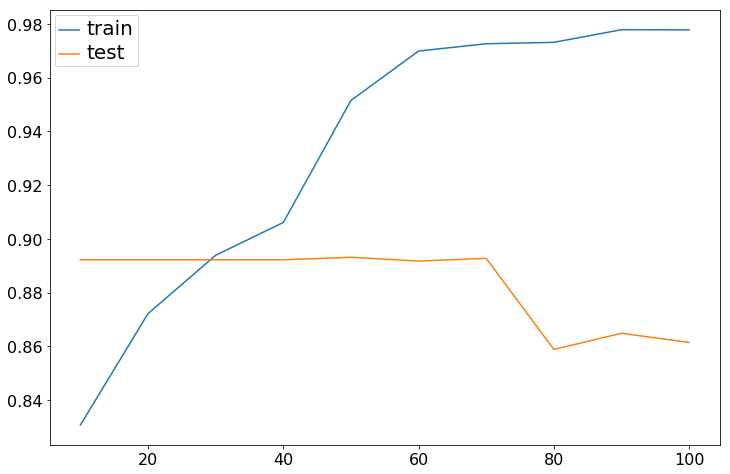

In [11]:
import numpy as np
np.random.seed(1989)
import matplotlib.pyplot as plt
%matplotlib inline
print('Build model...')

metrics = pd.DataFrame(0, index=["train","test"], columns=np.arange(10, 101, 10))
for i in np.arange(10, 101, 10)/100:
    print(i)
    no = int(round(i*len(x_train)))
    
    model = Sequential()
    model.add(Embedding(max_features, 100, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(50))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print( model.summary() )

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    history = model.fit(
        x_train[:no],              # features
        y_train[:no],              # labels
        epochs=5,                     # numbers of epoch
        batch_size=64,        # define batch size
        verbose=1,                    # the most extended verbose
        validation_split=0.1          # 90% for train and 10% for validation
    )

    predictions = model.predict_classes(x_train[:no], verbose=1)
    metrics.loc["train",i*100]= f1_score(y_train[:no], predictions)    
    
    predictions = model.predict_classes(x_test, verbose=1)
    metrics.loc["test",i*100]= f1_score(y_test, predictions) 
    
metrics = metrics.T
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
metrics[:][:].plot(ax=ax, fontsize=16)
legend = ax.get_legend()
legend.prop.set_size(20)

print(classification_report(y_test, predictions))    